# Install

In [27]:
import os
os.chdir('./GymGo-master')

FileNotFoundError: [Errno 2] No such file or directory: './GymGo-master'

In [28]:
#! pip install -e .

In [29]:
import gym
import random
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
from gym_go import state_utils, govars

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import iqr
import pickle

# env

In [32]:
# sample a image
go_env = gym.make('gym_go:go-v0', size=3, reward_method = "heuristic")
go_env.step(2)
state1 = go_env.state()[0:2]
#state1

In [33]:
# 8 same symmetries
def all_symmetries(image):
    """
    :param image: A (C, BOARD_SIZE, BOARD_SIZE) numpy array, where C is any number
    :return: All 8 orientations that are symmetrical in a Go game over the 2nd and 3rd axes
    (i.e. rotations, flipping and combos of them)
    """
    symmetries = []

    for i in range(8):
        x = image
        if (i >> 0) % 2:
            # Horizontal flip
            x = np.flip(x, 2)
        if (i >> 1) % 2:
            # Vertical flip
            x = np.flip(x, 1)
        if (i >> 2) % 2:
            # Rotation 90 degrees
            x = np.rot90(x, axes=(1, 2))
            
        symmetries.append(x)

    return symmetries
#all_symmetries(state1)

In [35]:
size = 3
# one state to num
def state2num(state1,size):
    # state1 is a size*size*6 matrix
    
    
    state1 = state1.astype(int)
    state = state1[0:2].reshape(size**2*2)
    num = int("".join(str(x) for x in state), 2)
    
    return num
state2num(state1, size)

# all states to num
def all_state2num(state1, size):
    # state1 is a size*size*6 matrix
    state1 = state1.astype(int)
    all_b = all_symmetries(state1[0].reshape(1,size,size))
    all_w = all_symmetries(state1[1].reshape(1,size,size))
    ls = []
    for i in range(8):
        state = np.concatenate((all_b[i].reshape(size**2),all_w[i].reshape(size**2)), axis=None)
        num = int("".join(str(x) for x in state), 2)
        ls.append(num)
    return ls

#state2num(state1, size), all_state2num(state1, size)

In [37]:
ls = all_state2num(state1, size)
l = dict()
l[2048] = 0

action = 9
def symmetry_action(ls, l, action, size):
    # ls is all symmetry fucntion
    # l is all keys in value function
    # action is an int
    
    # return rotated action and flag indicating if the state exists
    flag = False
    state = ls[0]
    for i in range(len(ls)):
        if ls[i] in l:
            flag = True
            if action == size**2:
                state = ls[i]
                break
            
            a = math.floor(action/size)
            b = action%size
            s = size - 1
            if i == 1:
                b = s-b
            elif i == 2:
                a = s-a
            elif i == 3:
                a = s-a
                b = s-b
            elif i == 4:
                b = a
                a = b
            elif i == 5:
                a = s-b
                b = a
            elif i == 6:
                a = b
                b = s-a
            elif i == 7:
                a = s-b
                b = s-a
            action = size * a + b
            state = ls[i]
            break
    return action, state, flag
[action, state, flag] = symmetry_action(ls, l, action, size)
#action, state, flag

In [38]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [39]:
def invalid_moves(state):
    # return a fixed size binary vector
    if game_ended(state):
        return np.zeros(action_size(state))
    return np.append(state[govars.INVD_CHNL].flatten(), 0)


def valid_moves(state):
    return 1 - invalid_moves(state)

In [40]:
# Program
class Learn(object):

    # board size, value function, action function
    def __init__(self, size):
        self.size = size
        # define state value function as a dict
        # key is position of b and w
        # value is state value (a number)
        self.value_function = dict()
        
        # add new state if not exist
        #if tuple(go_env.state()[0:2].reshape(size**2*2)) not in value_function: 
        #    value_function[tuple(go_env.state()[0:2].reshape(size**2*2))] = 0
        
        # define action value function as a dict
        # key is position of b and w
        # value is action value (an array)
        self.action_function = dict()
        
        #if tuple(go_env.state()[0:2].reshape(size**2*2)) not in action_function:
        #    action_function[tuple(go_env.state()[0:2].reshape(size**2*2))] = np.zeros(size**2+1)
        
        self.env = gym.make('gym_go:go-v0', size=self.size, reward_method = "heuristic")
        
        #self.state = self.env.state()[0:2].reshape(size**2*2)
    
    # helper
    #def intersection(self, lst1, lst2):
    #    lst3 = [value for value in lst1 if value in lst2]
    #    return lst3
    
    ## load policy
    def load_policy(self, dictionary):
        self.action_function = dictionary
        
        

    ## greedy policy
    def apply_policy(self, states, epsilon):
        """
        Apply the policy of the agent
        Args:
            state: tuple of length 2
            epsilon: exploration probability, 0 for greedy behavior, 1 for pure exploration
        Returns:
            the selected action for the state under the current policy
        """
        ## random
        if np.random.uniform(0, 1) < epsilon:
            action_index = self.env.uniform_random_action()
        else: 
            # if not in action function, build a new one
            
            [x, state, flag] = symmetry_action(states, self.action_function, 0, self.size)
            if not flag:
                action_index = self.env.uniform_random_action()
                #self.action_function[state] = np.zeros(self.size**2+1)
            #if state not in self.action_function:
            #    self.action_function[state] = np.zeros(self.size**2+1)
            
            else:
                # actions with max value
                greedy_action_value = np.max(self.action_function[state])
                greedy_indices = [i for i, a in enumerate(self.action_function[state]) if
                              a == greedy_action_value]

                valid = np.nonzero(self.env.valid_moves())[0]

                # overlap between max and valid action 
                #idx = intersection(greedy_indices, valid)
                #if idx == []:
                #    action_idx = self.size**2
                #print(greedy_indices)
                #else:
                #    action_idx = np.random.choice(intersection(greedy_indices, valid))
                action_idx = np.random.choice(greedy_indices)
                [action_index, x, x] = symmetry_action(states, self.action_function, action_idx, self.size)
                if action_index not in valid:
                    action_index = self.env.uniform_random_action()
        
        
        return action_index
    
    def sarsa_td(self, n_episodes=1000, alpha=0.01, gamma=0.9):
        """
        Run the sarsa control algorithm (TD0), finding the optimal policy and action function
        :param n_episodes: int, amount of episodes to train
        :param alpha: learning rate
        :param gamma: discount factor of future rewards
        :return: finds the optimal policy for move chess
        """
        
        for k in range(n_episodes):
            self.env = gym.make('gym_go:go-v0', size=self.size, reward_method = "heuristic")
            
            done = False
            epsilon = max(1 / (1 + k), 0.05)
            
            while not done:
                # current state - action idx
                #state = self.env.state()[0:2].reshape(self.size**2*2)
                # state = state2num(self.env.state(), self.size)
            
                states = all_state2num(self.env.state(),self.size)
                action_index = self.apply_policy(states, epsilon)
                
                
                # current state - action value
                ## check all rotations
                [action_idx, state, flag] = symmetry_action(states, self.action_function, action_index, self.size)
                #print(action_idx, action_index)
                if not flag:
                    self.action_function[state] = np.zeros(self.size**2+1)
                #print(states,action_idx)
                action_value = self.action_function[state][action_idx]
                
                
                # step
                successor_state, reward, done, info = self.env.step(action_index)
                
                
                # successor state - action idx
                #successor_state = successor_state1[0:2].reshape(self.size**2*2)
                #successor_state = state2num(successor_state1, self.size)
                successor_states = all_state2num(successor_state, self.size)
                successor_action_index = self.apply_policy(successor_states, epsilon)
                
                
                
                # successor state - action value
                ## check all rotations
                [successor_action_idx, successor_state, flag2] = symmetry_action(successor_states, 
                                                                                 self.action_function, 
                                                                                 successor_action_index,
                                                                                self.size)
                #print(successor_action_idx, successor_action_index)
                if not flag2:
                    self.action_function[successor_state] = np.zeros(self.size**2+1)
                    
                successor_action_value = self.action_function[successor_state][successor_action_idx]
                
                # update action value function
                q_update = alpha * (reward + gamma * successor_action_value - action_value)
                self.action_function[state][action_idx] += q_update
                
                if done:
                    break
                
                # white
                action = self.env.uniform_random_action()
                state, reward, done, info = self.env.step(action)
        

# reward for random-policy

In [117]:
# non policy
rewards_inter_non = [0]*25

for j in range(1):
    reward_non = []
    value_non = []
    for i in range(1): 
        non = Learn(size = 3)
        #a.env = gym.make('gym_go:go-v0', size=size, reward_method = 'real')
        done = False

        while not done:
            
            reward_non.append(reward)
            action = non.env.uniform_random_action()
            state, reward, done, info = non.env.step(action)
            if not done:
                reward_non.append(reward)
    print(j)
                
            
    
    rewards_inter_non[j] = reward_non
    value_non[j] = value_non
    
        

TypeError: unhashable type: 'list'

# TD Traing
## train

In [73]:
# TD training
size = 3
td = Learn(size = size)
td.sarsa_td(n_episodes=10000)

KeyboardInterrupt: 

### Save policy

In [41]:
# save policy
#dict_data = td.action_function
#a_file = open("data.pkl", "wb")
#pickle.dump(dict_data, a_file)
#a_file.close()
size = 3
td = Learn(size = size)
a_file = open("data.pkl", "rb")
output = pickle.load(a_file)

a_file.close()
td.load_policy(output)

## reward & Value Function

In [47]:
# after traning 
rewards_td = [0]*25
#value_td = [0]*25
states_start = [0]*25
states_end = [0]*25
states_inter = [0]*25
for j in range(25):
    print(j)
    reward_td = []
    start = []
    end = []
    inter  = []

    for i in range(1000): 
        td.env = gym.make('gym_go:go-v0', size=size,  reward_method = "heuristic")

        done = False

        states = all_state2num(td.env.state(),size)
        #state = a.env.state()[0:2].reshape(size**2*2)
        action_index = td.apply_policy(states, 0.1)
        #action = go_env.uniform_random_action()
        state, reward, done, info = td.env.step(action_index)

        idx, s, f = symmetry_action(all_state2num(td.env.state(), size), td.action_function, 0, size)

        start.append(s)
        reward_td.append(reward)

        while not done:
             # white    
            action = td.env.uniform_random_action()
            state, reward, done, info = td.env.step(action)

            if done:
                break


            states = all_state2num(td.env.state(),size)

            #state = a.env.state()[0:2].reshape(size**2*2)
            action_index = td.apply_policy(states, 0.1)
            #action = go_env.uniform_random_action()
            state, reward, done, info = td.env.step(action_index)
            #print(reward)
            [action_idx, state, flag] = symmetry_action(states, td.action_function, action_index, size)
            
            # state 
            inter.append(state)
                
            # reward
            if not done:
                reward_td.append(reward)


        idx, s, f = symmetry_action(states, td.action_function, 0, size) 
        
        end.append(s)
        
    states_start[j] = start
    states_end[j] = end
    states_inter[j] = inter
    rewards_td[j]=reward_td
        
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


# Evaluation
## reward

In [370]:
# increace winning rate by ~25%
rewards.count(1.0),rewards.count(0),rewards.count(-1)

(837, 47, 116)

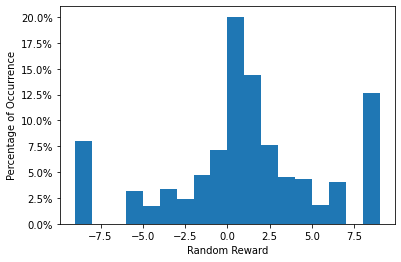

[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


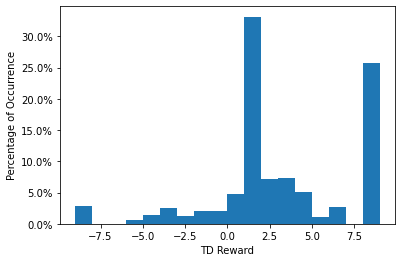

[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]


In [21]:
# Random
from matplotlib.ticker import PercentFormatter
#np.save('rewards_inter_non.npy', rewards_inter_non)
rewards_inter_non = np.load('rewards_inter_non.npy', allow_pickle=True)
plt.hist(rewards_inter_non[1], weights=np.ones(len(rewards_inter_non[1])) / len(rewards_inter_non[1]), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Random Reward')
plt.show()
non_iqr = []
for i in rewards_inter_non:
    non_iqr.append(iqr(i))
print(non_iqr)
#plt.boxplot(non_iqr)

# TD
#np.save('rewards_td.npy', rewards_td)
rewards_td = np.load('rewards_td.npy', allow_pickle=True)
plt.hist(rewards_td[1], weights=np.ones(len(rewards_td[1])) / len(rewards_td[1]), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('TD Reward')

plt.show()
td_iqr = []
for i in rewards_td:
    td_iqr.append(iqr(i))
#plt.boxplot(td_iqr)
print(td_iqr)

## Value Function

In [63]:
start_values = []
for i in states_start:
    start_value = []
    for j in i:
        if j not in td.action_function:
            start_value.append(0)
        else:
            start_value.append(np.sum(td.action_function[j]))
    start_values.append(start_value)
    
end_values = []
for i in states_end:
    end_value = []
    for j in i:
        if j not in td.action_function:
            end_value.append(0)
        else:
            end_value.append(np.sum(td.action_function[j]))
    end_values.append(end_value)
    
inter_values = []
for i in states_inter:
    inter_value = []
    for j in i:
        if j not in td.action_function:
            inter_value.append(0)
        else:
            inter_value.append(np.sum(td.action_function[j]))
    inter_values.append(inter_value)
    
all_values = []
for i in range(25):
    all_value = []
    all_value.extend(start_values[i])
    all_value.extend(end_values[i])
    all_value.extend(inter_values[i])
    all_values.append(all_value)
#ax = sns.distplot(ls, bins=20, kde=False)
#plt.ylabel('No. Occurance')
#plt.xlabel('State Value (Starting States)')
#plt.show()

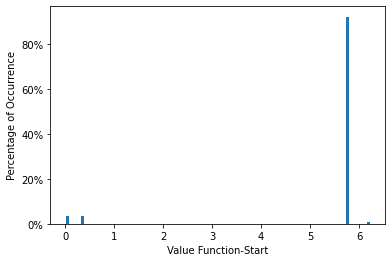

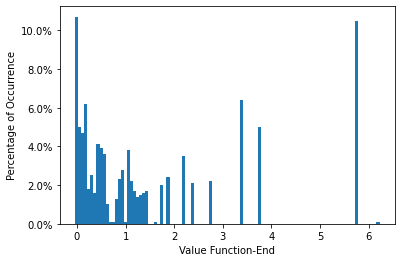

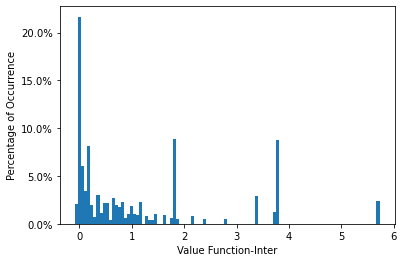

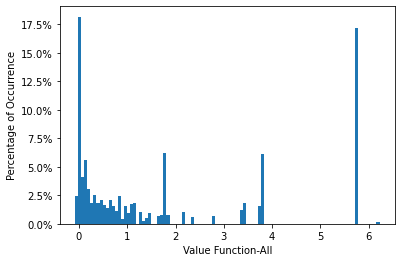

In [70]:
#np.save('start_values.npy', start_values)
#np.save('end_values.npy', end_values)
#np.save('inter_values.npy', inter_values)
#np.save('all_values.npy', all_values)

#start_values = np.load('start_values.npy', allow_pickle=True)
#end_values = np.load('end_values.npy', allow_pickle=True)
#inter_values = np.load('inter_values.npy', allow_pickle=True)
#all_values = np.load('all_values.npy', allow_pickle=True)

plt.hist(start_values[1], weights=np.ones(len(start_values[1])) / len(start_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-Start')
plt.show()

plt.hist(end_values[1], weights=np.ones(len(end_values[1])) / len(end_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-End')
plt.show()

plt.hist(inter_values[1], weights=np.ones(len(inter_values[1])) / len(inter_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-Inter')
plt.show()

plt.hist(all_values[1], weights=np.ones(len(all_values[1])) / len(all_values[1]), bins = 100)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('Value Function-All')
plt.show()



Text(0.5, 0, 'States')

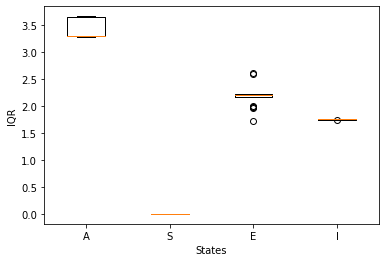

In [82]:
all_iqr_value = []
start_iqr_value = []
end_iqr_value = []
inter_iqr_value = []
for i in range(25):
    all_iqr_value.append(iqr(all_values[i]))
    start_iqr_value.append(iqr(start_values[i]))
    end_iqr_value.append(iqr(end_values[i]))
    inter_iqr_value.append(iqr(inter_values[i]))
plt.boxplot([all_iqr_value,start_iqr_value, end_iqr_value, inter_iqr_value], 
            labels=list('ASEI'))
plt.ylabel('IQR')
plt.xlabel('States')